In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#The data relevant to our research question is in the following two files. Note these contain background information about patients (age, sex, etc), as well as information obtained at the paitent's arrival at the ED. 
# Although there is other data available, it is obtained later in the patient's ED stay.
ed_edstays_df = pd.read_csv('../ed_data/edstays.csv.gz', compression='gzip')
ed_triage_df = pd.read_csv('../ed_data/triage.csv.gz', compression='gzip') 
hosp_patients_df = pd.read_csv('../hosp_data/patients.csv.gz', compression='gzip')  

In [3]:
ed_edstays_df['stay_id'].nunique()

425087

In [4]:
ed_edstays_df[ed_edstays_df['stay_id'] == 31046462]

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition
85168,12027310,NaN,31046462,2167-08-17 18:33:00,2167-08-17 18:33:00,M,ASIAN - ASIAN INDIAN,UNKNOWN,OTHER


In [5]:
# Merge two dataframes edstays and triage
from MergeCleanClasses import DataMerge 
df_merge = DataMerge(ed_edstays_df, ed_triage_df, hosp_patients_df).get_dataframe()

In [6]:
df_merge.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'disposition', 'admission_age',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain',
       'acuity', 'chiefcomplaint'],
      dtype='object')

In [7]:
# Clean the dataframe by replacing abnormal values with np.nan in multiple columns, including
#   stay_length_hours, temperature, resprate, sbp, dbp, o2sat, pain
# Special treatments for several columns:
# 1. For temperature, scale temperature values by 10 (if between 8.24 and 10.10) and by 0.10 (if between 824 and 1010),
#      and convert temperature from Celsius to Fahrenheit (if betweeen 28 and 43.3)
# 2. Exclude data where disposition is 'eloped', 'left without being seen' or 'left against medical advice'
# 3. For pain, 
#   if it's a range (number-number), replace this range by the average (e.g., 6-9 is replaced by 7.5);
#   if it's a number followed by a symbol, strip off the extra symbols and just keep the number  (e.g., '9+' is replaced by 9);
#   it's a single number, convert to a float (covers integer and decimal). Round down to 10 if the result is larger than 10.
# 4. Condense race into fewer categories: 'White', 'OTHER', 'HISPANIC/LATINO', 'ASIAN', 'BLACK', nan,
#    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'AMERICAN INDIAN/ALASKA NATIVE'
# All above are copied from Emilie's Cleaning.ipynb

from MergeCleanClasses import DataCleaner
cleaner=DataCleaner(df_merge)
cleaner.clean_data()
df_cleaned = cleaner.get_dataframe()


In [8]:
df_cleaned.describe()

,subject_id,hadm_id,stay_id,admission_age,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,stay_length_minutes,pain_cleaned_advanced
count,4.112770e+05,2.013750e+05,4.112770e+05,411205.000000,387762.000000,394457.000000,391279.000000,391062.000000,393302.000000,392440.000000,404408.000000,411277.000000,384815.000000
mean,1.500718e+07,2.499449e+07,3.499728e+07,53.028820,98.088368,85.040101,17.575659,98.471866,134.957685,77.408262,2.616481,434.927633,4.321386
std,2.879890e+06,2.888908e+06,2.888242e+06,20.613883,0.975337,17.716119,5.566926,17.325963,22.525219,15.080065,0.709232,394.538181,3.818743
min,1.000003e+07,2.000002e+07,3.000001e+07,18.000000,82.400000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,1.251482e+07,2.248901e+07,3.249803e+07,35.000000,97.600000,72.000000,16.000000,97.000000,120.000000,68.000000,2.000000,216.950000,0.000000
50%,1.501357e+07,2.499871e+07,3.499245e+07,54.000000,98.000000,84.000000,18.000000,99.000000,133.000000,77.000000,3.000000,332.000000,5.000000
75%,1.750042e+07,2.749299e+07,3.750440e+07,69.000000,98.600000,96.000000,18.000000,100.000000,148.000000,87.000000,3.000000,503.716667,8.000000
max,1.999999e+07,2.999981e+07,3.999996e+07,91.000000,110.000000,256.000000,1820.000000,9322.000000,312.000000,400.000000,5.000000,9677.000000,10.000000


In [9]:
df_cleaned.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'chiefcomplaint', 'stay_length_minutes', 'pain_cleaned_advanced',
       'race_condensed'],
      dtype='object')

In [10]:
print(len(df_cleaned['subject_id'].unique()))
print(len(df_cleaned['stay_id'].unique()))

201657
411277


In [11]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df_cleaned, shuffle = True, random_state = 489,test_size=.1)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

# What about null values? There are 76 data with null admission_age.

In [12]:
train.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,admission_age,temperature,...,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,stay_length_minutes,pain_cleaned_advanced,race_condensed
198136,13693110,NaN,34656289,2130-01-13 16:59:00,2130-01-13 20:38:00,F,WHITE,WALK IN,39.0,98.1,...,12.0,100.0,130.0,66.0,3,3.0,Palpitations,219.0,3.0,White
271146,11211939,29843627.0,36379343,2156-11-07 04:31:00,2156-11-07 22:24:00,F,WHITE - RUSSIAN,WALK IN,91.0,97.1,...,18.0,94.0,166.0,73.0,yes,2.0,"Dizziness, s/p Fall",1073.0,NaN,White
327102,17927957,NaN,37694994,2129-02-10 10:26:00,2129-02-10 13:41:00,F,WHITE,WALK IN,60.0,96.9,...,18.0,100.0,137.0,57.0,8,3.0,LEFT EYE HEMATOMA,195.0,8.0,White
16348,12485364,NaN,30382138,2152-07-15 11:49:00,2152-07-15 16:04:00,F,HISPANIC/LATINO - PUERTO RICAN,WALK IN,43.0,98.1,...,18.0,97.0,99.0,77.0,0,3.0,Asthma exacerbation,255.0,0.0,HISPANIC/LATINO
196399,19364518,27928048.0,34615303,2149-06-11 22:28:00,2149-06-12 17:26:00,F,WHITE,AMBULANCE,55.0,98.3,...,16.0,98.0,153.0,70.0,2,2.0,"Chest pain, Back pain",1138.0,2.0,White


In [13]:
df_cleaned[df_cleaned['stay_length_minutes'] <= 5].count()

subject_id               229
hadm_id                   13
stay_id                  229
intime                   229
outtime                  229
gender                   229
race                     229
arrival_transport        229
admission_age            229
temperature               39
heartrate                 44
resprate                  42
o2sat                     44
sbp                       43
dbp                       43
pain                      61
acuity                    68
chiefcomplaint           228
stay_length_minutes      229
pain_cleaned_advanced     46
race_condensed           119
dtype: int64

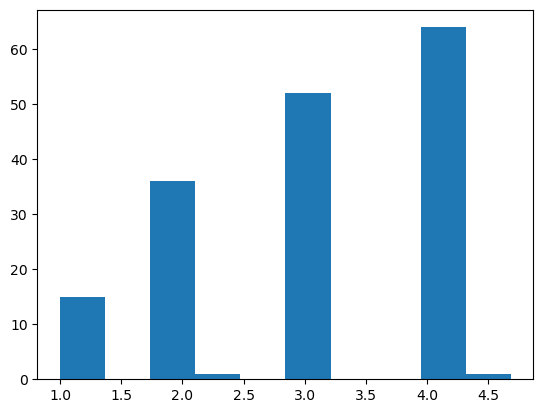

In [15]:
plt.hist(df_cleaned[df_cleaned['stay_length_minutes'] < 5]['stay_length_minutes'])
plt.show()